# Hot-day proportions (Tmax > 30 °C) in five Korean cities, 1980–2024

In [1]:
pip install meteostat pandas matplotlib statsmodels

Note: you may need to restart the kernel to use updated packages.


In [1]:
# =========================
# 0. Imports & helpers
# =========================
from datetime import datetime
from meteostat import Daily, Point, Stations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from meteostat import Point 

# Wilson CI (95%) helper
from math import sqrt
def wilson_ci(successes, n, z=1.96):
    if n == 0: return (np.nan, np.nan)
    p = successes / n
    denom = 1 + z**2/n
    center = (p + z**2/(2*n)) / denom
    half = (z/denom) * sqrt((p*(1-p)/n) + (z**2/(4*n**2)))
    return center - half, center + half

# Nice plot fonts
plt.rcParams["figure.figsize"] = (9, 4.5)
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

In [2]:
from datetime import datetime
from meteostat import Stations, Daily
import pandas as pd, numpy as np, os

START, END = datetime(1980,1,1), datetime(2024,12,31)

def best_station_id(lat, lon, start=START, end=END, k=15):
    cand = (Stations().nearby(lat, lon).inventory('daily', (start, end)).fetch(k))
    if cand.empty: return None
    if 'id' not in cand.columns: cand = cand.reset_index().rename(columns={'index':'id'})
    def overlap_days(r):
        s = max(pd.to_datetime(r['daily_start']), pd.Timestamp(start))
        e = min(pd.to_datetime(r['daily_end']),   pd.Timestamp(end))
        return max((e - s).days + 1, 0)
    cand['overlap'] = cand.apply(overlap_days, axis=1)
    cand = cand.sort_values(['overlap','distance'], ascending=[False, True])
    return cand.iloc[0]['id']

def merged_daily(lat, lon, start=START, end=END, k=5):
    cand = (Stations().nearby(lat, lon).inventory('daily', (start, end)).fetch(k))
    ids = cand.index.tolist() if 'id' not in cand.columns else cand['id'].tolist()
    return Daily(ids, start, end, model=False).fetch()

def fetch_obs_series(city, lat, lon, merge=False):
    """If merge=True, stitch top nearby stations. Else use best single station."""
    if merge:
        df = merged_daily(lat, lon, START, END).reset_index()
        src_label = "merged"
    else:
        stid = best_station_id(lat, lon)
        src_label = f"station {stid if stid else 'coords'}"
        df = Daily(stid if stid else (lat,lon), START, END, model=False).fetch().reset_index()
    if df.empty:
        print(f"[{city}] no data")
        return pd.DataFrame(columns=['date','tmax','city'])
    df = df.rename(columns={'time':'date'})
    df['city'] = city
    print(f"[{city}] using {src_label} -> {len(df)} rows")
    return df[['date','tmax','city']]

# --- Decide per city
CITIES = {
    "Seoul":   (37.5665, 126.9780, False),  # False = single station
    "Daejeon": (36.3504, 127.3845, False),
    "Daegu":   (35.8714, 128.6014, False),
    "Busan":   (35.1796, 129.0756, True),   # True = merge nearby stations
    "Gwangju": (35.1595, 126.8526, True),
}

frames = []
for name, (lat, lon, use_merge) in CITIES.items():
    frames.append(fetch_obs_series(name, lat, lon, merge=use_merge))

raw = (pd.concat(frames, ignore_index=True)
         .dropna(subset=['tmax'])
         .assign(year=lambda d: pd.to_datetime(d['date']).dt.year))


[Seoul] using station 47108 -> 16420 rows
[Daejeon] using station 47133 -> 14607 rows
[Daegu] using station 47138 -> 12997 rows


[Busan] using merged -> 66820 rows


[Gwangju] using merged -> 70494 rows


In [3]:
import pandas as pd, numpy as np
from math import sqrt
import matplotlib.pyplot as plt

# 1) Clean + quality filter
raw["date"] = pd.to_datetime(raw["date"])
raw["year"] = raw["date"].dt.year
raw["hot"] = (raw["tmax"] > 30).astype(int)

MIN_VALID_DAYS_PER_YEAR = 330
year_ok = (raw.groupby(["city","year"])
             .size().rename("n_days").reset_index())
year_ok = year_ok[year_ok["n_days"] >= MIN_VALID_DAYS_PER_YEAR]
df = raw.merge(year_ok[["city","year"]], on=["city","year"], how="inner")

In [6]:
df

,date,tmax,city,year,hot,decade
0,1980-01-01,7.0,Seoul,1980,0,1980
1,1980-01-02,6.0,Seoul,1980,0,1980
2,1980-01-03,6.0,Seoul,1980,0,1980
3,1980-01-04,0.0,Seoul,1980,0,1980
4,1980-01-05,-1.0,Seoul,1980,0,1980
...,...,...,...,...,...,...
164444,2024-10-16,26.4,Gwangju,2024,0,2020
164445,2024-10-24,22.8,Gwangju,2024,0,2020
164446,2024-10-31,23.2,Gwangju,2024,0,2020
164447,2024-11-16,24.4,Gwangju,2024,0,2020


In [19]:
df

,date,tmax,city,year,hot,decade
0,1980-01-01,7.0,Seoul,1980,0,1980
1,1980-01-02,6.0,Seoul,1980,0,1980
2,1980-01-03,6.0,Seoul,1980,0,1980
3,1980-01-04,0.0,Seoul,1980,0,1980
4,1980-01-05,-1.0,Seoul,1980,0,1980
...,...,...,...,...,...,...
220693,2023-09-14,27.8,Daegu,2023,0,2020
220694,2023-11-01,24.5,Daegu,2023,0,2020
220695,2024-01-13,10.1,Daegu,2024,0,2020
220696,2024-02-12,11.6,Daegu,2024,0,2020


### Step 1 — Year quality filter (keep years with ≥330 valid days)

In [20]:
import pandas as pd

MIN_VALID_DAYS_PER_YEAR = 330

# how many days per city-year?
year_counts = (df.groupby(["city","year"])
                 .size().rename("n_days").reset_index())

# keep only good years
good_years = year_counts[year_counts["n_days"] >= MIN_VALID_DAYS_PER_YEAR][["city","year"]]
df_qc = df.merge(good_years, on=["city","year"], how="inner")

# quick sanity check: show recent coverage
check = (df_qc.groupby(["city","year"]).size()
           .rename("n_days").reset_index())
print(check[check["year"] >= 2018]
        .pivot(index="year", columns="city", values="n_days")
        .fillna(0).astype(int))


city  Busan  Daegu  Daejeon  Gwangju  Seoul
year                                       
2018    388    388        0        0      0
2019    386    386        0        0      0
2020    355    355        0        0      0
2022    927    927      340      936    336
2023    374    374      333      380      0
2024    372    372        0      386      0


### Step 2 — De-duplicate by city+date (keep the max tmax for that day)

In [21]:
# 2a) de-duplicate: for each city+date, keep the highest Tmax observed that day
df_dedup = (df.groupby(["city", "date"], as_index=False)["tmax"].max())

# rebuild helpers
df_dedup["year"] = pd.to_datetime(df_dedup["date"]).dt.year
df_dedup["decade"] = (df_dedup["year"] // 10) * 10
df_dedup["hot"] = (df_dedup["tmax"] > 30).astype("int8")


In [22]:
MIN_VALID_DAYS_PER_YEAR = 330

year_counts = (df_dedup.groupby(["city","year"])
                         .size().rename("n_days").reset_index())

good_years = year_counts[year_counts["n_days"] >= MIN_VALID_DAYS_PER_YEAR][["city","year"]]
df_qc = df_dedup.merge(good_years, on=["city","year"], how="inner")

# sanity: recent coverage should be ≤ 366 and nonzero where present
check = (df_qc.groupby(["city","year"]).size()
           .rename("n_days").reset_index())
print(check[check["year"] >= 2018]
        .pivot(index="year", columns="city", values="n_days")
        .fillna(0).astype(int))


city  Busan  Daegu  Daejeon  Gwangju  Seoul
year                                       
2018    331    331        0        0      0
2019    332    332        0        0      0
2022    342    342      340      342    336
2023    334    334      333      333      0


### Step 3 — compute decadal proportions + CIs (Wald & Wilson) and margin of error

In [23]:
import numpy as np
import pandas as pd
from math import sqrt
from scipy.stats import norm

alpha = 0.05
z = norm.ppf(1 - alpha/2)

# use the QC’d, de-duplicated data
d = df_qc.copy()

# decadal counts per city
dec = (d.groupby(["city","decade"])["hot"]
         .agg(n_hot="sum", n_days="count")
         .reset_index())

# MLE of population proportion (sample proportion)
dec["p_hat"] = dec["n_hot"] / dec["n_days"]

# Wald CI (to match the class notes)
se = np.sqrt(dec["p_hat"]*(1 - dec["p_hat"]) / dec["n_days"])
dec["wald_lo"] = dec["p_hat"] - z*se
dec["wald_hi"] = dec["p_hat"] + z*se
dec["ME_wald"] = (dec["wald_hi"] - dec["wald_lo"]) / 2   # estimation error (half-width)

# Wilson CI (better coverage; use for plots)
def wilson_ci(s, n, z=1.96):
    if n == 0: return (np.nan, np.nan)
    p = s/n
    denom = 1 + z**2/n
    center = (p + z**2/(2*n)) / denom
    half = (z/denom) * np.sqrt((p*(1-p)/n) + (z**2/(4*n**2)))
    return center - half, center + half

dec[["wilson_lo","wilson_hi"]] = dec.apply(
    lambda r: pd.Series(wilson_ci(r["n_hot"], r["n_days"], z)), axis=1
)

# tidy table for reporting
dec_out = (dec.assign(decade=lambda x: x["decade"].astype(str)+"s",
                      prop=lambda x: x["p_hat"])
             .loc[:, ["city","decade","n_days","n_hot","prop",
                      "wald_lo","wald_hi","ME_wald","wilson_lo","wilson_hi"]]
             .sort_values(["city","decade"]))
dec_out.head(12)


,city,decade,n_days,n_hot,prop,wald_lo,wald_hi,ME_wald,wilson_lo,wilson_hi
0,Busan,1980s,3653,527,0.144265,0.132871,0.155659,0.011394,0.133245,0.156033
1,Busan,1990s,3634,583,0.160429,0.148497,0.172362,0.011932,0.148856,0.172719
2,Busan,2000s,3629,558,0.153761,0.142025,0.165497,0.011736,0.142392,0.165863
3,Busan,2010s,3209,545,0.169835,0.156843,0.182826,0.012991,0.157240,0.183219
4,Busan,2020s,676,135,0.199704,0.169568,0.229841,0.030137,0.171302,0.231500
5,Daegu,1980s,3653,527,0.144265,0.132871,0.155659,0.011394,0.133245,0.156033
6,Daegu,1990s,3634,583,0.160429,0.148497,0.172362,0.011932,0.148856,0.172719
7,Daegu,2000s,3629,558,0.153761,0.142025,0.165497,0.011736,0.142392,0.165863
8,Daegu,2010s,3209,545,0.169835,0.156843,0.182826,0.012991,0.157240,0.183219
9,Daegu,2020s,676,135,0.199704,0.169568,0.229841,0.030137,0.171302,0.231500


### Step 4 — hypothesis tests (across-decade difference + monotonic trend)

In [24]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency
import statsmodels.api as sm
import statsmodels.formula.api as smf

results = []
for city, sub in df_qc.groupby("city", group_keys=False):
    # --- chi-square test: are proportions different across decades?
    T = (sub.groupby("decade")["hot"]
           .agg(n_hot="sum", n_days="count"))
    T["n_not"] = T["n_days"] - T["n_hot"]
    chi2, p_chi2, dof, _ = chi2_contingency(np.vstack([T["n_hot"], T["n_not"]]))

    # effect size: Cramer's V (2 x K table -> min(1, K-1) = 1)
    N = T["n_days"].sum()
    cramers_v = np.sqrt(chi2 / N)

    # --- logistic trend: hot ~ decade (numeric), day-level
    sub2 = sub.copy()
    sub2["dec_c"] = sub2["decade"] - sub2["decade"].mean()
    fit = smf.glm("hot ~ dec_c", data=sub2, family=sm.families.Binomial()).fit()

    # log-odds slope per decade
    beta10 = float(fit.params["dec_c"]) * 10
    p_trend = float(fit.pvalues["dec_c"])

    # optional: translate to ~percentage-point change per decade around overall p
    pbar = sub["hot"].mean()
    approx_pp_change = 100 * pbar * (1 - pbar) * beta10  # Δp ≈ p(1-p)*β

    results.append({
        "city": city,
        "chi2": chi2, "df": dof, "p_chi2": p_chi2, "cramers_V": cramers_v,
        "logit_slope_per_decade": beta10, "p_trend": p_trend,
        "approx_pp_change_per_decade": approx_pp_change
    })

stats_table = pd.DataFrame(results).sort_values("city")
stats_table


,city,chi2,df,p_chi2,cramers_V,logit_slope_per_decade,p_trend,approx_pp_change_per_decade
0,Busan,17.943459,4,1.265896e-03,0.034818,0.066221,3.831596e-04,0.883862
1,Daegu,17.943459,4,1.265896e-03,0.034818,0.066221,3.831596e-04,0.883862
2,Daejeon,25.018870,4,4.987220e-05,0.048844,0.075090,8.600698e-04,0.801947
3,Gwangju,15.854026,4,3.221426e-03,0.033920,0.058812,2.991550e-03,0.771549
4,Seoul,47.906744,4,9.869882e-10,0.064201,0.173462,4.367866e-11,1.493536


### Step 5 — make the final visuals + compact summary table

#### 5A) One-figure panel: proportions by decade (Wilson 95% CI)

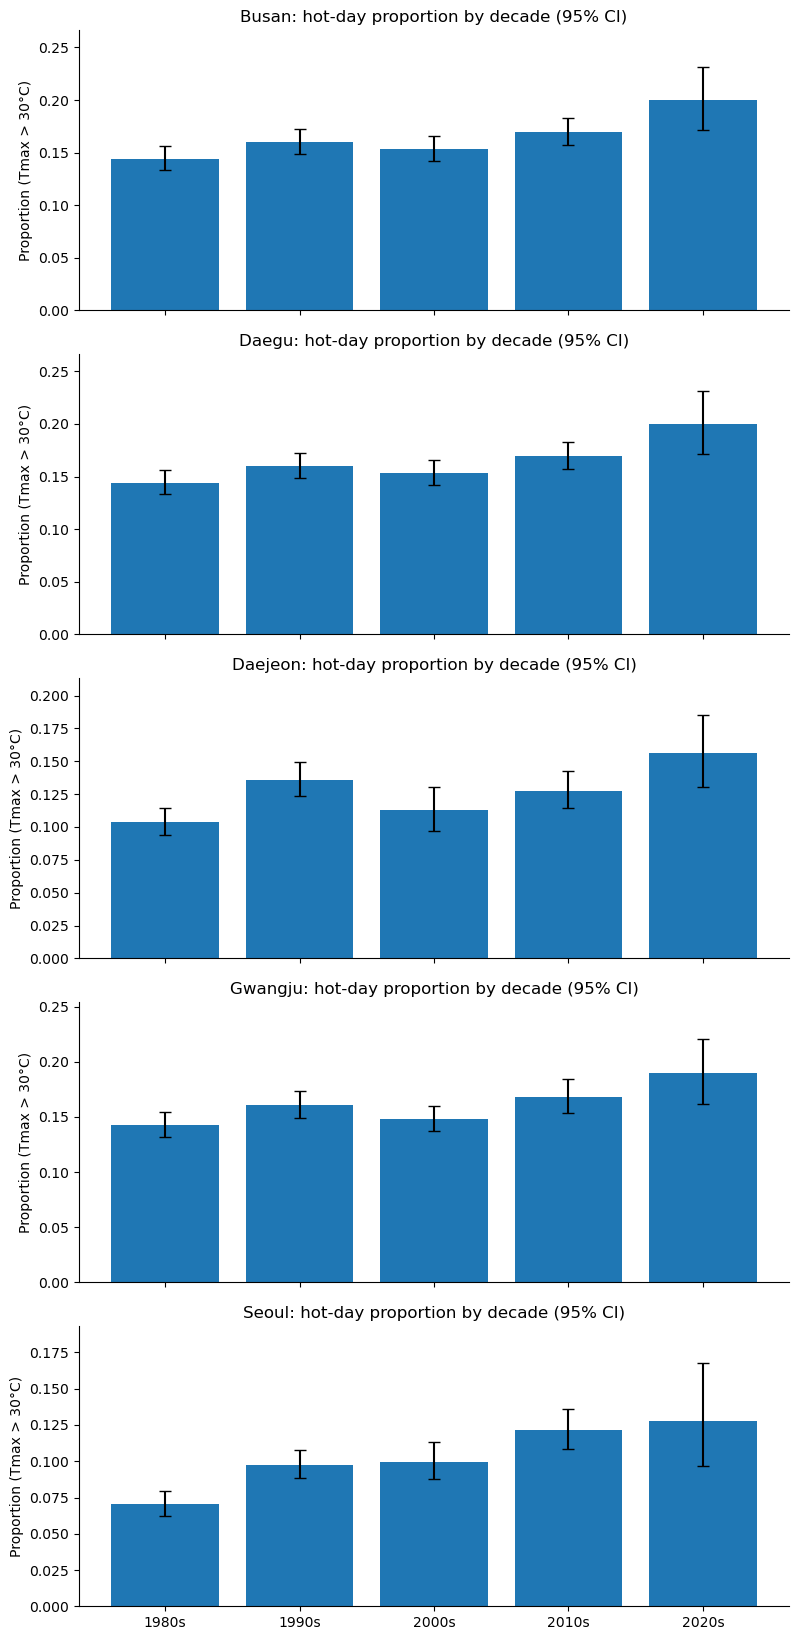

In [25]:
import numpy as np
import matplotlib.pyplot as plt

cities = dec_out["city"].unique()
n = len(cities)
fig, axes = plt.subplots(n, 1, figsize=(8, 3.3*n), sharex=True)

for ax, city in zip(axes, cities):
    sub = dec_out[dec_out.city==city].sort_values("decade")
    x = np.arange(len(sub))
    y = sub["prop"].values
    lo = y - sub["wilson_lo"].values
    hi = sub["wilson_hi"].values - y

    ax.bar(x, y, yerr=[lo, hi], capsize=4)
    ax.set_title(f"{city}: hot-day proportion by decade (95% CI)")
    ax.set_ylabel("Proportion (Tmax > 30°C)")
    ax.set_ylim(0, max(0.01, (y+hi).max()*1.15))

axes[-1].set_xticks(np.arange(len(sub)))
axes[-1].set_xticklabels(sub["decade"].tolist(), rotation=0)
plt.tight_layout()
plt.show()

### 5B) Compact summary table: 1980s → 2020s change (percentage points)

In [26]:
wide = (dec_out.pivot(index="decade", columns="city", values="prop")
              .sort_index())
summary = pd.DataFrame({
    "1980s": wide.loc["1980s"],
    "2020s": wide.loc["2020s"] if "2020s" in wide.index else np.nan
})
summary["pp_change_80s_to_20s"] = (summary["2020s"] - summary["1980s"]) * 100
summary = summary.round({"1980s":3, "2020s":3, "pp_change_80s_to_20s":2})
summary


,1980s,2020s,pp_change_80s_to_20s
city,,,
Busan,0.144,0.200,5.54
Daegu,0.144,0.200,5.54
Daejeon,0.104,0.156,5.24
Gwangju,0.142,0.190,4.73
Seoul,0.070,0.128,5.77


In [28]:
from scipy.stats import t, chi2
import numpy as np
import pandas as pd

# use your QC’d, deduped data frame: df_qc with columns date, city, decade, tmax

q = (df_qc.groupby(["city","decade"])["tmax"]
       .agg(n="count", mean="mean", s2="var").reset_index())

alpha = 0.05

def t_interval(m, s2, n):
    if n<=1: return (np.nan, np.nan)
    se = np.sqrt(s2/n); tcrit = t.ppf(1 - alpha/2, df=n-1)
    return m - tcrit*se, m + tcrit*se

def var_interval(s2, n):
    if n<=1: return (np.nan, np.nan)
    lo = (n-1)*s2 / chi2.ppf(1 - alpha/2, df=n-1)
    hi = (n-1)*s2 / chi2.ppf(alpha/2, df=n-1)
    return lo, hi

q[["mean_lo","mean_hi"]] = q.apply(lambda r: pd.Series(t_interval(r["mean"], r["s2"], r["n"])), axis=1)
q[["var_lo","var_hi"]]   = q.apply(lambda r: pd.Series(var_interval(r["s2"], r["n"])), axis=1)

# pretty table for report
q_out = (q.assign(decade=lambda d: d["decade"].astype(str)+"s")
           .loc[:, ["city","decade","n","mean","mean_lo","mean_hi","s2","var_lo","var_hi"]]
           .sort_values(["city","decade"]))
q_out.head()


,city,decade,n,mean,mean_lo,mean_hi,s2,var_lo,var_hi
0,Busan,1980s,3653,20.699863,20.423597,20.976130,72.530726,69.315644,75.975917
1,Busan,1990s,3634,21.147826,20.876449,21.419204,69.622089,66.528152,72.938064
2,Busan,2000s,3629,21.073877,20.800162,21.347593,70.729395,67.584158,74.100511
3,Busan,2010s,3209,20.962854,20.659358,21.266351,76.887011,73.258813,80.792931
4,Busan,2020s,676,19.907249,19.119875,20.694622,108.705977,97.980538,121.303792


In [27]:
stats_table.to_csv("hotday_stats_by_city.csv", index=False)
dec_out.to_csv("hotday_proportions_by_city_decade.csv", index=False)
summary.to_csv("hotday_80s_to_20s_summary.csv")
print("Saved: hotday_stats_by_city.csv, hotday_proportions_by_city_decade.csv, hotday_80s_to_20s_summary.csv")


Saved: hotday_stats_by_city.csv, hotday_proportions_by_city_decade.csv, hotday_80s_to_20s_summary.csv


# SUMMARY

### A) Figure — “Change from 1980s → 2020s"

Saved fig_change_80s_20s_clean.png


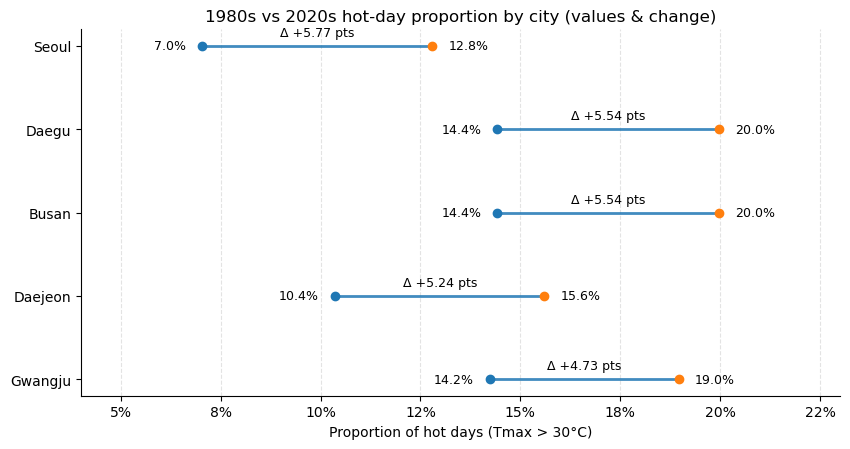

In [42]:
# === Figure 1: 1980s vs 2020s hot-day proportion by city (dumbbell) ===
# Prereq: dec_out with columns ["city","decade","prop"] where decade is like "1980s","1990s",...

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FuncFormatter

# 1) wide table (decade x city) → keep 1980s & 2020s → rows = cities
wide = (dec_out.pivot(index="decade", columns="city", values="prop")
               .sort_index())
summary = (wide.reindex(["1980s", "2020s"]).T).dropna(subset=["1980s","2020s"])

# 2) compute change and order cities by change
summary["change_pts"] = (summary["2020s"] - summary["1980s"]) * 100
summary = summary.sort_values("change_pts")  # smallest → largest change
y = np.arange(len(summary))

# 3) plot
fig, ax = plt.subplots(figsize=(8.6, 4.6))

# connectors + endpoints
ax.hlines(y, summary["1980s"], summary["2020s"], linewidth=2, alpha=0.85)
ax.plot(summary["1980s"], y, "o")   # 1980s
ax.plot(summary["2020s"], y, "o")   # 2020s

# annotate values and Δ (percentage points)
for i, (v80, v20, dpp) in enumerate(zip(summary["1980s"], summary["2020s"], summary["change_pts"])):
    ax.text(v80 - 0.004, y[i], f"{v80*100:.1f}%", va="center", ha="right", fontsize=9)
    ax.text(v20 + 0.004, y[i], f"{v20*100:.1f}%", va="center", ha="left",  fontsize=9)
    mid = (v80 + v20) / 2
    ax.text(mid, y[i] + 0.16, f"Δ {dpp:+.2f} pts", va="center", ha="center", fontsize=9)

# labels/ticks/grid
ax.set_yticks(y)
ax.set_yticklabels(summary.index.tolist())
ax.set_title("1980s vs 2020s hot-day proportion by city (values & change)")
ax.set_xlabel("Proportion of hot days (Tmax > 30°C)")
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x*100:.0f}%"))
ax.grid(True, axis="x", linestyle="--", alpha=0.35)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# 4) smart x-axis limits (pad by ~3 percentage points; clamp to 0–30%)
xmin = summary[["1980s","2020s"]].min().min() - 0.03
xmax = summary[["1980s","2020s"]].max().max() + 0.03
xmin = max(0.00, round(xmin, 3))
xmax = min(0.30, round(xmax, 3))     # adjust 0.30 if your values are larger
ax.set_xlim(xmin, xmax)
ax.xaxis.set_major_locator(MultipleLocator(0.025))  # 2.5% steps

plt.tight_layout()
plt.savefig("fig_change_80s_20s_clean.png", dpi=240)
print("Saved fig_change_80s_20s_clean.png")


### B) Figures — Per-city bars with Wilson 95% CI (one PNG per city)

In [30]:
import numpy as np
import matplotlib.pyplot as plt

for city in dec_out["city"].unique():
    sub = dec_out[dec_out.city==city].sort_values("decade")
    x = np.arange(len(sub))
    y = sub["prop"].values
    lo = y - sub["wilson_lo"].values
    hi = sub["wilson_hi"].values - y

    plt.figure(figsize=(6.4, 3.6))
    plt.bar(x, y, yerr=[lo, hi], capsize=4)
    plt.xticks(x, sub["decade"].tolist())
    plt.ylabel("Proportion (Tmax > 30°C)")
    plt.title(f"{city}: hot-day proportion by decade (Wilson 95% CI)")
    plt.tight_layout()
    fname = f"fig_{city.lower()}_decadal_props.png"
    plt.savefig(fname, dpi=200)
    plt.close()
    print("Saved", fname)

Saved fig_busan_decadal_props.png
Saved fig_daegu_decadal_props.png
Saved fig_daejeon_decadal_props.png
Saved fig_gwangju_decadal_props.png
Saved fig_seoul_decadal_props.png


### C1) Decadal proportions table (rounded, with Wilson CI)
### C2) Stats table (chi-square & trend)
### C3) Optional quantitative add-on (mean/variance intervals for Tmax)

In [44]:
pip install xlsxwriter

Note: you may need to restart the kernel to use updated packages.


In [45]:
import pandas as pd

# Round a bit for readability (tweak as you like)
dec_x = (dec_out.copy()
         .assign(prop=lambda d: d["prop"].round(4),
                 wald_lo=lambda d: d["wald_lo"].round(4),
                 wald_hi=lambda d: d["wald_hi"].round(4),
                 ME_wald=lambda d: d["ME_wald"].round(4),
                 wilson_lo=lambda d: d["wilson_lo"].round(4),
                 wilson_hi=lambda d: d["wilson_hi"].round(4))
         .sort_values(["city","decade"]))

stats_x = (stats_table.copy()
           .rename(columns={"logit_slope_per_decade":"logit_slope_per_decade"})
           .round({"chi2":3, "p_chi2":6, "logit_slope_per_decade":3, "p_trend":6}))

# Optional: Tmax mean/variance intervals table if you built `q` earlier
have_q = "q" in globals()

with pd.ExcelWriter("hotday_outputs.xlsx", engine="xlsxwriter") as writer:
    dec_x.to_excel(writer, index=False, sheet_name="proportions_by_decade")
    stats_x.to_excel(writer, index=False, sheet_name="tests_by_city")

    if have_q:
        q_x = (q.copy()
               .rename(columns={"n":"N"})
               .round({"mean":2,"mean_lo":2,"mean_hi":2,"s2":2,"var_lo":2,"var_hi":2}))
        q_x.to_excel(writer, index=False, sheet_name="tmax_mean_var_intervals")

print("Saved hotday_outputs.xlsx")

Saved hotday_outputs.xlsx


In [50]:
dec_out

,city,decade,n_days,n_hot,prop,wald_lo,wald_hi,ME_wald,wilson_lo,wilson_hi
0,Busan,1980s,3653,527,0.144265,0.132871,0.155659,0.011394,0.133245,0.156033
1,Busan,1990s,3634,583,0.160429,0.148497,0.172362,0.011932,0.148856,0.172719
2,Busan,2000s,3629,558,0.153761,0.142025,0.165497,0.011736,0.142392,0.165863
3,Busan,2010s,3209,545,0.169835,0.156843,0.182826,0.012991,0.157240,0.183219
4,Busan,2020s,676,135,0.199704,0.169568,0.229841,0.030137,0.171302,0.231500
5,Daegu,1980s,3653,527,0.144265,0.132871,0.155659,0.011394,0.133245,0.156033
6,Daegu,1990s,3634,583,0.160429,0.148497,0.172362,0.011932,0.148856,0.172719
7,Daegu,2000s,3629,558,0.153761,0.142025,0.165497,0.011736,0.142392,0.165863
8,Daegu,2010s,3209,545,0.169835,0.156843,0.182826,0.012991,0.157240,0.183219
9,Daegu,2020s,676,135,0.199704,0.169568,0.229841,0.030137,0.171302,0.231500


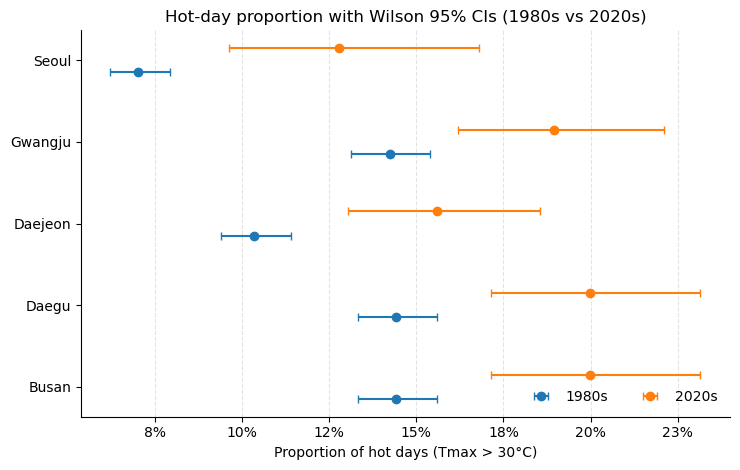

In [46]:
# Build CI-ready subset for 1980s & 2020s
sub = (dec_out[dec_out["decade"].isin(["1980s","2020s"])]
         .copy()
         .sort_values(["decade","city"]))

import numpy as np, matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

cities = sub["city"].unique()
decades = ["1980s","2020s"]
y = np.arange(len(cities))

fig, ax = plt.subplots(figsize=(7.5, 4.8))

offset = {"1980s": -0.15, "2020s": +0.15}  # small vertical separation
for d in decades:
    s = sub[sub["decade"]==d].set_index("city").reindex(cities)
    x = s["prop"].values
    lo = x - s["wilson_lo"].values
    hi = s["wilson_hi"].values - x
    ax.errorbar(x, y + offset[d], xerr=[lo, hi], fmt="o", capsize=3, label=d)

ax.set_yticks(y)
ax.set_yticklabels(cities)
ax.xaxis.set_major_formatter(FuncFormatter(lambda v,_: f"{v*100:.0f}%"))
ax.set_xlabel("Proportion of hot days (Tmax > 30°C)")
ax.set_title("Hot-day proportion with Wilson 95% CIs (1980s vs 2020s)")
ax.grid(True, axis="x", linestyle="--", alpha=0.35)
ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
ax.legend(frameon=False, ncols=2, loc="lower right")
plt.tight_layout(); plt.savefig("fig_forest_80s_20s.png", dpi=240)


Saved fig_forest_80s_20s_annotated.png


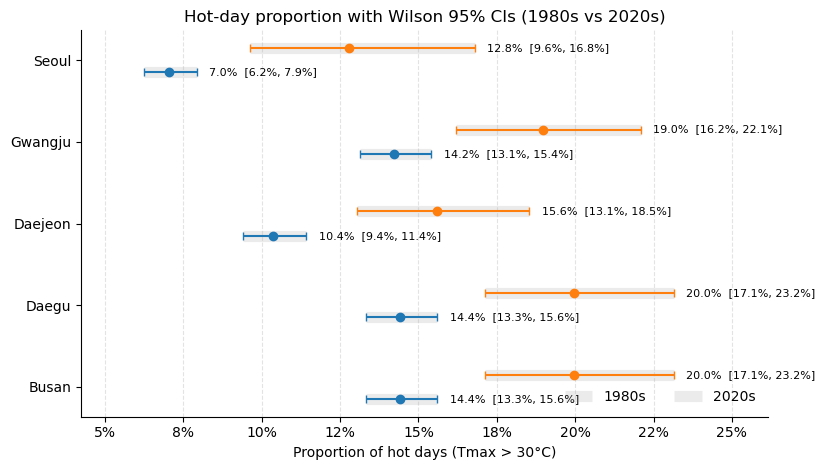

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# --- prepare subset for 1980s & 2020s
sub = (dec_out[dec_out["decade"].isin(["1980s","2020s"])]
       .copy()
       .sort_values(["decade","city"]))

cities = sub["city"].unique()
decades = ["1980s","2020s"]
y = np.arange(len(cities))
offset = {"1980s": -0.15, "2020s": +0.15}

fig, ax = plt.subplots(figsize=(8.4, 4.8))

for d in decades:
    s = sub[sub["decade"]==d].set_index("city").reindex(cities)

    p   = s["prop"].values
    lo  = s["wilson_lo"].values
    hi  = s["wilson_hi"].values
    yrow = y + offset[d]

    # 1) draw a faint band for the CI (visual ME)
    ax.hlines(yrow, lo, hi, colors="tab:gray", alpha=0.15, linewidth=8, zorder=1)

    # 2) draw the classic CI whisker + point
    ax.errorbar(p, yrow, xerr=[p - lo, hi - p], fmt="o", capsize=3, label=d if d=="1980s" else None, zorder=2)

    # 3) annotate numeric values: p [lo, hi]
    for xx, yy, plo, phi in zip(p, yrow, lo, hi):
        ax.text(phi + 0.004, yy, f"{xx*100:.1f}%  [{plo*100:.1f}%, {phi*100:.1f}%]",
                va="center", ha="left", fontsize=8)

# cosmetics
ax.set_yticks(y); ax.set_yticklabels(cities)
ax.xaxis.set_major_formatter(FuncFormatter(lambda v,_: f"{v*100:.0f}%"))
ax.set_xlabel("Proportion of hot days (Tmax > 30°C)")
ax.set_title("Hot-day proportion with Wilson 95% CIs (1980s vs 2020s)")
ax.grid(True, axis="x", linestyle="--", alpha=0.35)
ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
ax.legend(["1980s","2020s"], frameon=False, loc="lower right", ncols=2)

# x-limits with padding
xmin = max(0, sub["wilson_lo"].min() - 0.02)
xmax = min(1, sub["wilson_hi"].max() + 0.03)
ax.set_xlim(xmin, xmax)

plt.tight_layout()
plt.savefig("fig_forest_80s_20s_annotated.png", dpi=240)
print("Saved fig_forest_80s_20s_annotated.png")


In [48]:
import pandas as pd

# 1) get 1980s & 2020s proportions from dec_out
w = (dec_out[dec_out["decade"].isin(["1980s","2020s"])]
       .pivot(index="city", columns="decade", values="prop"))

# 2) compute Δ in percentage points
summary = w.copy()
summary["Δ (pp)"] = (summary["2020s"] - summary["1980s"]) * 100

# 3) pull p-values from your stats table
tests = stats_table.loc[:, ["city", "p_chi2", "p_trend"]].set_index("city")

# 4) join & pretty round
compact = (summary.join(tests, how="inner")
                    .rename(columns={"1980s":"1980s p̂", "2020s":"2020s p̂"}))

compact = compact[["1980s p̂","2020s p̂","Δ (pp)","p_chi2","p_trend"]]
compact = compact.round({"1980s p̂":3,"2020s p̂":3,"Δ (pp)":2,"p_chi2":6,"p_trend":6})

# 5) drop any city missing a decade (rare) to avoid NaNs
compact = compact.dropna().reset_index()

compact

,city,1980s p̂,2020s p̂,Δ (pp),p_chi2,p_trend
0,Busan,0.144,0.200,5.54,0.001266,0.000383
1,Daegu,0.144,0.200,5.54,0.001266,0.000383
2,Daejeon,0.104,0.156,5.24,0.000050,0.000860
3,Gwangju,0.142,0.190,4.73,0.003221,0.002992
4,Seoul,0.070,0.128,5.77,0.000000,0.000000


In [49]:
with pd.ExcelWriter("hotday_outputs.xlsx", engine="openpyxl", mode="a", if_sheet_exists="replace") as w:
    compact.to_excel(w, index=False, sheet_name="compact_summary")
print("Wrote sheet: compact_summary")

Wrote sheet: compact_summary
